# 1. Теоретическая часть

## 1.2 Доказать, что оптимальные направления PCA совпадают с собственными векторами матрицы ковариаций

## Постановка задачи
Пусть дан **центрированный** набор данных \( X \in \mathbb{R}^{n \times m} \), где:
- \\( n \\) — количество объектов,
- \\( m \\) — количество признаков.

**Матрица ковариаций** определяется как:
\\[
\Sigma = \frac{1}{n-1} X^T X.
\\]

---

## Цель PCA
Найти **направление** (единичный вектор \\( w \in \mathbb{R}^m \\)), при проекции данных на которое достигается **максимальная дисперсия**. Математически задача формулируется как:
\\[
\max_w \, \text{Var}(Xw) = \frac{1}{n-1} \|Xw\|^2 = w^T \Sigma w,
\\]
при условии \\( \|w\| = 1 \\).

---

## Решение задачи оптимизации

### Метод множителей Лагранжа
Для максимизации \\( w^T \Sigma w \\) с ограничением \\( \|w\| = 1 \\) вводим **лагранжиан**:
\\([
\mathcal{L}(w, \lambda) = w^T \Sigma w - \lambda (w^T w - 1).
\\)]
Приравнивая производную к нулю:
\\[
\frac{\partial \mathcal{L}}{\partial w} = 2\Sigma w - 2\lambda w = 0 \implies \Sigma w = \lambda w.
\\]
Это уравнение показывает, что:
- \\( w \\) — **собственный вектор** матрицы \\( \Sigma \\),
- \\( \lambda \\) — соответствующее **собственное значение**.

### Спектральное разложение
Матрица ковариаций \\( \Sigma \\) симметрична и положительно полуопределена, поэтому допускает **спектральное разложение**:
\\[
\Sigma = \sum_{i=1}^m \lambda_i v_i v_i^T,
\\]
где:
- \\( \lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_m \geq 0 \\) — собственные значения,
- \\( \{v_i\} \\) — ортонормированные собственные векторы.

###  Максимизация дисперсии
Любой единичный вектор \\( w \\) можно представить в виде:
\\[
w = \sum_{i=1}^m a_i v_i, \quad \text{где } \sum_{i=1}^m a_i^2 = 1.
\\]
Подставляя это в выражение для дисперсии:
\\[
w^T \Sigma w = \sum_{i=1}^m \lambda_i a_i^2.
\\]
Максимум достигается, когда \\( a_1 = 1 \\) (для \\( \lambda_{\text{max}} \\)), а остальные \\( a_j = 0 \\). Таким образом, оптимальное направление:
\\[
w = v_1,
\\]
где \\( v_1 \\) — собственный вектор, соответствующий наибольшему собственному значению \\( \lambda_1 \\).

---

## Последующие главные компоненты
Для нахождения следующих компонент добавляется условие **ортогональности** предыдущим направлениям:
1. **Вторая компонента** соответствует \\( v_2 \\) (собственный вектор для \\( \lambda_2 \\)).
2. Аналогично, \\( k \\)-я компонента — \\( v_k \\) с \\( \lambda_k \\).

---

## Вывод
**Главные компоненты** в PCA совпадают с **собственными векторами** матрицы ковариаций \\( \Sigma \\), упорядоченными по убыванию собственных значений:
- Первая компонента (\\( v_1 \\)) максимизирует дисперсию,
- Последующие компоненты (\\( v_2, v_3, \dots \\)) обеспечивают максимальную остаточную дисперсию при ортогональности предыдущим направлениям.

Этот результат следует из свойств спектрального разложения и задачи условной оптимизации.

# 2. Практическая часть

In [1]:
from typing import List, Tuple
import math
import random

In [2]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import csv

## 2.1 Напишем отдельный класс матрицы с основными операциями

In [3]:
class Matrix:

    def __init__(self, data):
        """
        Инициализация матрицы.
        """
        if not all(len(row) == len(data[0]) for row in data):
            raise ValueError("Все строки матрицы должны иметь одинаковую длину")
        self.data = data
        self.rows = len(data)
        self.cols = len(data[0]) if self.rows > 0 else 0

    def __add__(self, other):
        """Сложение матриц."""
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы ни одного размера")
        result = [
            [self.data[i][j] + other.data[i][j] for j in range(self.cols)]
            for i in range(self.rows)
        ]
        return Matrix(result)

    def __sub__(self, other):
        """Вычитание матриц.."""
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы ни одного размера")
        result = [
            [self.data[i][j] - other.data[i][j] for j in range(self.cols)]
            for i in range(self.rows)
        ]
        return Matrix(result)

    def __mul__(self, scalar):
        """Умножение матрицы на скаляр."""
        if not isinstance(scalar, (int, float)):
            raise TypeError("Можно умножать только на скаляр")
        return Matrix([
            [elem * scalar for elem in row]
            for row in self.data
        ])

    def __matmul__(self, other):
        """Умножение матриц (ака оператор @ из нампая)."""
        if self.cols != other.rows:
            raise ValueError(
                "Число столбцов первой матрицы должно совпадать с числом строк второй"
            )
        result = [
            [
                sum(a * b for a, b in zip(self.row(i), other.col(j)))
                for j in range(other.cols)
            ]
            for i in range(self.rows)
        ]
        return Matrix(result)

    def transpose(self):
        """Возвращает транспонированную матрицу."""
        return Matrix([list(col) for col in zip(*self.data)])

    def minor(self, row, col):
        """
        Возвращает минор матрицы через разложение.
        """
        if self.rows != self.cols:
            raise ValueError("Матрица не квадратная")
        new_data = [
            r[:col] + r[col + 1:]
            for i, r in enumerate(self.data)
            if i != row
        ]
        return Matrix(new_data)

    def determinant(self):
        """Вычисляет определитель матрицы методом Гаусса."""
        if self.rows != self.cols:
            raise ValueError("Матрица не квадратная")

        mat = [row.copy() for row in self.data]
        n = self.rows
        det = 1.0

        for i in range(n):

            pivot = max(range(i, n), key=lambda x: abs(mat[x][i]))
            if abs(mat[pivot][i]) < 1e-10:
                return 0.0

            if pivot != i:
                mat[i], mat[pivot] = mat[pivot], mat[i]
                det *= -1

            det *= mat[i][i]
            for j in range(i + 1, n):
                factor = mat[j][i] / mat[i][i]
                for k in range(i, n):
                    mat[j][k] -= factor * mat[i][k]

        return det

    def trace(self):
        """Возвращает след матрицы (сумму диагональных элементов)."""
        if self.rows != self.cols:
            raise ValueError("След определен только для квадратных матриц")
        return sum(self.data[i][i] for i in range(self.rows))

    def __str__(self):
        """Строковое представление матрицы."""
        return "\n".join(["\t".join(map(str, row)) for row in self.data])

    def __getitem__(self, indices):
        """Возвращает элемент по индексам [i][j]."""
        i, j = indices
        if i >= self.rows or j >= self.cols:
            raise IndexError("Индекс выходит за границы матрицы")
        return self.data[i][j]

    def row(self, i):
        """Возвращает i-ю строку матрицы."""
        if i >= self.rows:
            raise IndexError("Индекс строки выходит за границы")
        return self.data[i]

    def col(self, j):
        """Возвращает j-й столбец матрицы."""
        if j >= self.cols:
            raise IndexError("Индекс столбца выходит за границы")
        return [row[j] for row in self.data]

    def copy(self):
        """Возвращает  копию матрицы."""
        return Matrix([row.copy() for row in self.data])

    def set(self, i, j, value):
        """Устанавливает значение элемента матрицы."""
        if i >= self.rows or j >= self.cols:
            raise IndexError("Индекс выходит за границы")
        self.data[i][j] = value

    def swap_rows(self, r1, r2):
        """Меняет местами две строки матрицы."""
        if r1 >= self.rows or r2 >= self.rows:
            raise IndexError("Индекс строки выходит за границы")
        self.data[r1], self.data[r2] = self.data[r2], self.data[r1]


## 2.1.1. EASY LEVEL


### Реализовать метод Гаусса для решения СЛАУ:

Метод Гаусса — алгоритм решения систем линейных алгебраических уравнений (СЛАУ) путём преобразования матрицы системы к **треугольному виду** с помощью элементарных операций над строками.

#### Основные этапы

##### 1. Прямой ход
Цель: Преобразование матрицы к верхнетреугольной форме.
1. **Выбор ведущего элемента (пивота)**:
   - На каждом шаге в текущем столбце ищется элемент с **максимальным абсолютным значением**.
   - Если необходимо, строки переставляются, чтобы пивот оказался на диагонали.
2. **Обнуление элементов под пивотом**:
   - Для каждой строки ниже текущей:
     - Вычисляется коэффициент:
       \\[
       \text{factor} = \frac{\text{Элемент под пивотом}}{\text{Пивот}}
       \\]
     - Из текущей строки вычитается строка с пивотом, умноженная на `factor`.



##### 2. Проверка на несовместность
После прямого хода анализируются строки матрицы:
- Если встречается строка вида:
  \\[
  [0 \quad 0 \quad \dots \quad 0 \,|\, d], \quad d \neq 0,
  \\]
  система **не имеет решений** .


##### 3. Обратный ход
Цель: Нахождение значений переменных.
1. Начинаем с последней строки верхнетреугольной матрицы.
2. Последовательно выражаем переменные снизу вверх:
   - Для каждой переменной \\( x_i \\):
     \\[
     x_i = \frac{b_i - \sum_{j=i+1}^n a_{ij}x_j}{a_{ii}}
     \\]


##### 4. Специфичные случаи
- **Несовместная система**:
  Наличие строки \\([0 \dots 0 \,|\\ d] \\, d \neq 0\\) → решений нет.
- **Бесконечно много решений**:
  Наличие строки \\([0 \dots 0 \,|\, 0]\\) → система имеет свободные переменные.


##### 5. Асимптотическая сложность по времени
Алгоритм имеет сложность \\( O(n^3) \\)

In [4]:
def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:
    """
    Вход:
      A: матрица коэффициентов (n×n)
      b: вектор правых частей (n×1)

    Выход:
      list[Matrix]: список базисных векторов решения системы

    Raises:
     ValueError: если система несовместна
    """
    n = A.rows

    augmented = []
    for i in range(n):
        row_i = []
        for j in range(n):
            row_i.append(A[i, j])
        row_i.append(b[i, 0])
        augmented.append(row_i)

    # Прямой ход Гаусса
    for col in range(n):
        pivot_row = max(range(col, n), key=lambda r: abs(augmented[r][col]))
        pivot_val = augmented[pivot_row][col]

        if abs(pivot_val) < 1e-10:
            continue

        if pivot_row != col:
            augmented[col], augmented[pivot_row] = augmented[pivot_row], augmented[col]
            pivot_val = augmented[col][col]

        # Нормируем ведущую строку
        for c in range(col, n + 1):
            augmented[col][c] /= pivot_val

        # Обнуляем столбец ниже pivot
        for r in range(col + 1, n):
            factor = augmented[r][col]
            if abs(factor) > 1e-12:
                for c in range(col, n + 1):
                    augmented[r][c] -= factor * augmented[col][c]

    # Проверка на несовместность
    # Если строка вида (0,0,...,0 | d), d != 0 => нет решений
    for row in augmented:
        left_part = row[:-1]
        right_part = row[-1]
        if all(abs(x) < 1e-10 for x in left_part) and abs(right_part) > 1e-10:
            raise ValueError("Система несовместна")

    # Обратный ход
    solution = [0.0] * n
    for i in range(n - 1, -1, -1):
        pivot_coeff = augmented[i][i]
        if abs(pivot_coeff) < 1e-10:
            continue

        val = augmented[i][-1]
        for j in range(i + 1, n):
            val -= augmented[i][j] * solution[j]
        solution[i] = val / pivot_coeff

    # Превращаем list solution -> Matrix (n×1)
    sol_matrix = Matrix([[x] for x in solution])
    return [sol_matrix]

### Реализовать функцию центрирования данных:
Метод, при котором среднее значение независимых переменных вычитается из всех значений

$$
X_{\text{centered}} = X - \text{mean}(X)
$$

In [5]:
def center_data(X: 'Matrix') -> 'Matrix':
    """
    Вход: матрица данных X (n×m)
    Выход: центрированная матрица X_centered (n×m)
    """
    n, m = X.rows, X.cols
    means = [sum(X.col(j)) / n for j in range(m)]
    mean_matrix = Matrix([[means[j] for _ in range(n)] for j in range(m)]).transpose()
    return X - mean_matrix

### Вычислить матрицу ковариаций:
Это матрица, составленная из попарных ковариаций элементов двух случайных векторов.

$$
C = \frac{1}{n-1} X^\top X
$$

In [6]:
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    n = X_centered.rows
    XT = X_centered.transpose()
    C = (XT @ X_centered) * (1 / (n - 1))
    return C


## 2.2.1. NORMAL LEVEL


### Найти собственные значения матрицы методом бисекции


#### Метод бисекции для поиска собственных значений матрицы

Метод бисекции применяется для нахождения корней характеристического уравнения матрицы \\( C \\):
\\[
\det(C - \lambda I) = 0,
\\]
где:
- \\( C \\) — исходная матрица,
- \\( \lambda \\) — искомые собственные значения,
- \\( I \\) — единичная матрица.

---

##### Алгоритм

###### 1. Оценка интервала методом Гершгорина
**Теорема Гершгорина** позволяет определить область локализации собственных значений:
- Для каждой строки \\( i \\) матрицы \\( C \\) вычисляется **радиус Гершгорина**:
  \\[
  R_i = \sum_{j \neq i} |c_{ij}|.
  \\]
- Все собственные значения лежат в объединении кругов:
  \\[
  \lambda \in \bigcup_{i=1}^n \left[ c_{ii} - R_i, \, c_{ii} + R_i \right].
  \\]
- Общий интервал поиска:
  \\[
  [a, \, b] = \left[ \min_i (c_{ii} - R_i), \, \max_i (c_{ii} + R_i) \right].
  \\]

---

###### 2. Поиск корней методом бисекции
Для каждого подынтервала \\([a, b]\\):
1. **Деление интервала**:
   Вычисляется середина интервала:
  \ \[
   \lambda_{\text{mid}} = \frac{a + b}{2}.
   \\]
2. **Анализ знака**:
   Определяется знак \\(\det(C - \lambda_{\text{mid}} I)\\).
   - Если знак меняется на \\([a, \lambda_{\text{mid}}]\\), корень ищется в этом подынтервале.
   - Иначе — в \\([\lambda_{\text{mid}}, b]\\).
3. **Итерации**:
   Процесс повторяется, пока не будет достигнута заданная точность \\( \varepsilon \\):
   \\[
   |b - a| < \varepsilon.
  \\]

---

###### 3. Вычисление определителя
Для матрицы \\( C - \lambda I \\) на каждом шаге:
- Используются **численные методы** (например, LU-разложение или метод Гаусса).
- **Сложность вычисления**: \\( O(n^3) \\) для матрицы размера \\( n \times n \\).

---

##### Особенности метода
- **Гарантированная сходимость**: Работает для непрерывных функций, меняющих знак на интервале.
- **Ограничения**:
  - Высокая вычислительная стоимость для больших матриц из-за многократного расчёта определителя.
  - Требует предварительной оценки интервала.
- **Применение**: Эффективен для симметричных матриц и небольших размерностей.

---


In [7]:
def bisection_method(func, a, b, epsilon):
    """
    Метод бисекции для поиска одного корня на отрезке [a, b]
    Возвращает приближение корня или None, если func(a)*func(b) > 0
    """
    fa = func(a)
    fb = func(b)
    if fa * fb > 0:
        return None

    while (b - a) / 2 > epsilon:
        c = (a + b) / 2
        fc = func(c)

        if abs(fc) < 1e-14:
            return c

        if fa * fc < 0:
            # корень лежит в [a, c]
            b = c
            fb = fc
        else:
            # корень лежит в (c, b]
            a = c
            fa = fc

    return (a + b) / 2


def find_all_roots(func, a, b, epsilon, tol=1e-5, step=0.1):
    """
    Ищет все корни func(x)=0 на [a, b], разбивая интервал с шагом step
    На каждом подотрезке, где есть смена знака, уточняет корень методом бисекции
    Параметры:
        func    - функция f(x)
        a, b    - границы интервала
        epsilon - точность для метода бисекции
        tol     - допуск при сравнении найденных корней
        step    - шаг разбиения
    Возвращает список всех найденных корней по возрастанию
    """
    roots = []

    x_points = []
    x_val = a
    while x_val < b:
        x_points.append(x_val)
        x_val += step
    if x_points[-1] < b:
        x_points.append(b)

    # Ищем смену знака на смежных подотрезках
    for i in range(len(x_points) - 1):
        x0, x1 = x_points[i], x_points[i + 1]
        f0, f1 = func(x0), func(x1)
        if f0 * f1 <= 0:
            # Уточняем корень методом бисекции
            root = bisection_method(func, x0, x1, epsilon)
            if root is not None:
                # Проверяем, нет ли уже близкого корня
                if not any(abs(root - r) <= tol for r in roots):
                    roots.append(root)

    return sorted(roots)

In [8]:
def direct_det_func(C, x):
    """
    Вычисляет det(C - xI) для квадратной матрицы C размера n×n
    Возвращает float.
    """
    n = C.rows

    new_data = []
    for i in range(n):
        row = []
        for j in range(n):
            val = C[i, j]
            if i == j:
                val -= x
            row.append(val)
        new_data.append(row)

    M = Matrix(new_data)
    return M.determinant()

In [9]:
def gershgorin_interval(C, eps=1e-6):
    """
    Возвращает (a, b), оценку интервала, где лежат все собственные значения C
    """
    n = C.rows
    left_candidates = []
    right_candidates = []
    for i in range(n):
        diag_val = C[i, i]
        row_sum = 0.0
        for j in range(n):
            if j != i:
                row_sum += abs(C[i, j])
        left_candidates.append(diag_val - row_sum)
        right_candidates.append(diag_val + row_sum)
    a = min(left_candidates) - eps
    b = max(right_candidates) + eps
    return a, b

In [10]:
def find_eigenvalues(C: 'Matrix', tol: float = 1e-6) -> List[float]:
    """
    Вход:
      C: матрица ковариаций (m×m)
      tol: допустимая погрешность
    Выход: список вещественных собственных значений
    """
    a, b = gershgorin_interval(C, eps=1e-6)

    def fdet(x):
        return direct_det_func(C, x)

    roots = find_all_roots(fdet, a, b, epsilon=1e-6, step=0.001, tol=tol)
    return roots

### Найти собственные векторы матрицы


 $$
  (C - \lambda I)v = 0
  $$

In [11]:
def solve_system(A: Matrix, B: Matrix) -> List[float]:
    sol = gauss_solver(A, B)
    sol_vec = sol[0]
    return [sol_vec[i, 0] for i in range(sol_vec.rows)]

In [12]:
def identity_matrix(n: int) -> Matrix:
    """Единичная матрица n×n"""
    return Matrix([[1.0 if i == j else 0.0 for j in range(n)] for i in range(n)])


def inverse_iteration(
        C: Matrix,
        lam: float,
        max_iter: int = 100,
        tol: float = 1e-8
) -> Matrix:
    """
    Находит собственный вектор, соответствующий λ, решая
      (C - λI) y_{k+1} = x_k
    и нормируя y, пока не сойдётся
    """
    n = C.rows
    I = identity_matrix(n)
    A = C - (I * lam)

    # стартовый случайный вектор x (n×1)
    x = Matrix([[random.random()] for _ in range(n)])

    for _ in range(max_iter):
        # решаем A y = x через ваш solve_system (gauss_solver внутри)
        y_list = solve_system(A, x)  # возвращает list[float] длины n
        # превращаем в Matrix-столбец
        y = Matrix([[v] for v in y_list])

        # нормировка y
        norm = math.sqrt(sum(y[i, 0] ** 2 for i in range(n)))
        if norm < tol:
            break
        y = y * (1.0 / norm)

        # проверяем изменение
        delta = max(abs(y[i, 0] - x[i, 0]) for i in range(n))
        x = y
        if delta < tol:
            break

    return x  # это приближённый собственный вектор λ


def find_eigenvectors(C: Matrix, eigenvalues: List[float]) -> List[Matrix]:
    """
    Для каждого λ из eigenvalues запускаем inverse_iteration
    и возвращаем список столбцовых Matrix-векторов
    """
    return [inverse_iteration(C, lam) for lam in eigenvalues]

### Вычислить долю объясненной дисперсии:


$$
        \gamma = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{m} \lambda_i},
$$

In [13]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вход:
      eigenvalues: список собственных значений
      k: число компонент
    Выход: доля объясненной дисперсии
    """
    m = len(eigenvalues)
    if m == 0:
        raise ValueError("Список собственных значений пуст")
    if k <= 0 or k > m:
        raise ValueError(f"Некорректное k={k} для списка из {m} собственных значений")

    total = sum(eigenvalues)
    if abs(total) < 1e-15:
        raise ValueError("Сумма собственных значений равна нулю (невозможно разделить)")

    sorted_eigs = sorted(eigenvalues, reverse=True)

    explained = sum(sorted_eigs[:k])
    return explained / total


## 2.3.1 HARD LEVEL и EXPERT LEVEL
Так как хард и эксперт лвлы связаны друг с другом они будут вместе (честно мне просто проще сразу написать РСА с автовыбором главных компонент)

### Реализовать полный алгоритм PCA

#### Метод главных компонент (PCA)

**Метод главных компонент (PCA)** — это техника снижения размерности данных, направленная на поиск ортогональных направлений (главных компонент), которые максимизируют дисперсию данных. Основные этапы алгоритма:

---

#### Алгоритм PCA

##### 1. Центрирование данных
- **Цель**: Устранить смещение данных относительно начала координат.
- **Действие**: Для каждого признака вычисляется среднее значение, которое затем вычитается из исходных данных:
  \\[
  X_{\text{centered}} = X - \bar{X},
  \\]
  где \\( \bar{X} \\) — вектор средних значений признаков.

---

##### 2. Вычисление ковариационной матрицы
- **Цель**: Оценить взаимосвязь между признаками.
- **Формула**:
  \\[
  \Sigma = \frac{1}{n-1} X_{\text{centered}}^T X_{\text{centered}},
  \\]
  где:
  - \\( n \\) — количество объектов,
  - \\( \Sigma \\) — ковариационная матрица размерности \\( m \times m \\) (для \\( m \\) признаков).

---

##### 3. Нахождение собственных значений и векторов
- **Собственные векторы**: Определяют направления главных компонент. Каждый вектор соответствует оси, вдоль которой данные имеют максимальную дисперсию.
- **Собственные значения**: Показывают важность компонент. Чем больше значение \\( \lambda_i \\), тем больше дисперсии объясняет соответствующая компонента.

**Уравнение**:
\\[
\Sigma \mathbf{v}_i = \lambda_i \mathbf{v}_i,
\\]
где \\( \mathbf{v}_i \\) — собственный вектор, \\( \lambda_i \\) — собственное значение.

---

##### 4. Выбор главных компонент
- **Сортировка**: Собственные значения упорядочиваются по убыванию: \\( \lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_m \\).
- **Выбор \\( k \\) компонент**: Количество \\( k \\) определяется на основе:
  - Желаемой размерности данных,
  - Доли объясненной дисперсии:
    \\[
    \text{Доля} = \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^m \lambda_i}.
    \\]

---

##### 5. Проекция данных
- **Преобразование**: Исходные данные проецируются на выбранные \\( k \\) главных компонент:
  \\[
  Z = X_{\text{centered}} \cdot V_k,
  \\]
  где \\( V_k \\) — матрица из \\( k \\) собственных векторов.




In [14]:
def pca(X: 'Matrix', k: int = None, threshold: float = 0.93) -> Tuple[Matrix, float, int, Matrix, List[float]]:
    """
    Вход:
      X: матрица данных (n×m)
      k: число главных компонент
    Выход:
      X_proj: проекция данных (n×k)
      : доля объяснённой дисперсии
    """
    # 0) удаление Nan
    X = handle_missing_values(X)
    # 1) Центрируем
    X_centered = center_data(X)
    n, m = X_centered.rows, X_centered.cols

    # 2) Ковариационная матрица (m×m)
    C = covariance_matrix(X_centered)

    # 3) Находим eigenvals, eigenvecs
    eigenvals = find_eigenvalues(C, tol=1e-6)
    eigenvecs = find_eigenvectors(C, eigenvals)

    # 4) Сортируем по убыванию
    combined = list(zip(eigenvals, eigenvecs))
    combined.sort(key=lambda x: x[0], reverse=True)
    sorted_evals = [pair[0] for pair in combined]
    sorted_evecs = [pair[1] for pair in combined]

    # 5) Если k не задан, выбираем auto_select_k
    if k is None:
        k = auto_select_k(sorted_evals, threshold)
    if k <= 0 or k > m:
        raise ValueError(f"Некорректное k={k} (должно быть 1..{m}).")

    # 6) Формируем матрицу W (m×k), столбцы - первые k eigenvecs
    W_data = []
    for i in range(m):
        row_i = []
        for comp_idx in range(k):
            row_i.append(sorted_evecs[comp_idx][i, 0])
        W_data.append(row_i)
    W = Matrix(W_data)  # (m×k)

    X_proj = X_centered @ W

    # 7) Доля объяснённой дисперсии
    gamma = explained_variance_ratio(sorted_evals, k)

    means = [sum(X.col(i)) / n for i in range(m)]

    return X_proj, gamma, k, W, means

### Добавить автоматический выбор числа главных компонент

$$
k = \min \left\{ k : \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{m} \lambda_i} \ge \text{threshold} \right\}
$$

In [15]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Вход:
      eigenvalues: список собственных значений
      threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """
    m = len(eigenvalues)
    if m == 0:
        raise ValueError("Список eigenvalues пуст.")

    total = sum(eigenvalues)
    if abs(total) < 1e-14:
        raise ValueError("Сумма собственных значений близка к 0, нельзя разделить")

    cumulative = 0.0
    for i, val in enumerate(eigenvalues, start=1):
        cumulative += val
        ratio = cumulative / total
        if ratio >= threshold:
            return i

    # Если даже все компоненты не достигают порога, то берём k = m
    return m

### Обработать пропущенные значения в данных

$$
X_{\text{filled}} = \begin{cases}
X_{ij}, & \text{если } X_{ij} \neq \text{NaN} \\\
\text{mean}(X_j), & \text{иначе}
\end{cases}
$$

In [16]:
def handle_missing_values(X: 'Matrix') -> 'Matrix':
    """
    Вход: матрица данных X (n×m) с возможными NaN
    Выход: матрица данных X_filled (n×m) без NaN
    """

    n, m = X.rows, X.cols

    col_means = [0.0] * m
    for j in range(m):
        count = 0
        summ = 0.0
        for i in range(n):
            val = X[i, j]
            if not math.isnan(val):
                summ += val
                count += 1

        if count == 0:
            col_means[j] = 0.0
        else:
            col_means[j] = summ / count

    X_filled = X.copy()
    for i in range(n):
        for j in range(m):
            val = X_filled[i, j]
            if math.isnan(val):
                X_filled.set(i, j, col_means[j])

    return X_filled

### Визуализировать проекцию данных на первые две главные компоненты.

In [17]:
def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    """
    Вход: проекция данных X_proj (n×2)
    Выход: объект Figure из Matplotlib
    """
    if X_proj.cols != 2:
        raise ValueError(f"Матрица X_proj должна быть (n×2), а не (n×{X_proj.cols})")

    n = X_proj.rows

    x_vals = [X_proj[i, 0] for i in range(n)]
    y_vals = [X_proj[i, 1] for i in range(n)]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_vals, y_vals, c='blue', alpha=0.7, edgecolors='none')

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Проекция на первые два главных компонента")

    return fig

### Вычислить среднеквадратическую ошибку восстановления данных:

$$
\text{MSE} = \frac{1}{n \cdot m} \sum_{i,j} (X_{\text{orig}} - X_{\text{recon}})^2
$$

In [18]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    """
    Вход:
      X_orig: исходные данные (n×m)
      X_recon: восстановленные данные (n×m)
    Выход: среднеквадратическая ошибка MSE
    """
    n, m = X_orig.rows, X_orig.cols

    if X_recon.rows != n or X_recon.cols != m:
        raise ValueError(f"Размеры X_recon ({X_recon.rows}×{X_recon.cols}) "
                         f"не совпадают с X_orig ({n}×{m}).")

    sse = 0.0
    for i in range(n):
        for j in range(m):
            diff = X_orig[i, j] - X_recon[i, j]
            sse += diff * diff

    mse = sse / (n * m)
    return mse

## Тестики


### 1. Тест метода Гаусса

In [19]:
def test_gauss():
    """Тестирование метода Гаусса для решения СЛАУ """

    # Тест 1: Система с единственным решением
    # 3x + 2y = 8
    # x - y = 1
    A1 = Matrix([[3, 2], [1, -1]])
    b1 = Matrix([[8], [1]])
    try:
        result = gauss_solver(A1, b1)
        x, y = result[0][0, 0], result[0][1, 0]

        # Проверка точности решения
        assert abs(x - 2.0) < 1e-6, f"Ожидалось x=2.0, получено {x}"
        assert abs(y - 1.0) < 1e-6, f"Ожидалось y=1.0, получено {y}"
        print(f"Тест 1: Решение x={x:.2f}, y={y:.2f} (верно)")

    except Exception as e:
        assert False, f"Тест 1: Неожиданная ошибка — {e}"

    # Тест 2: Несовместная система
    # x + y = 3
    # 0x + 0y = 5
    A2 = Matrix([[1, 1], [0, 0]])
    b2 = Matrix([[3], [5]])
    try:
        gauss_solver(A2, b2)
        assert False, "Тест 2: Ожидалось исключение для несовместной системы"
    except ValueError:
        print("Тест 2: Система несовместна (верно)")
    except Exception as e:
        assert False, f"Тест 2: Неправильный тип ошибки — {type(e).__name__}"

    # Тест 3: Система с бесконечным числом решений
    # 2x + 4y = 6
    # x + 2y = 3
    A3 = Matrix([[2, 4], [1, 2]])
    b3 = Matrix([[6], [3]])
    try:
        solutions = gauss_solver(A3, b3)
        # Проверка базисного решения (например, x = 1, y = 1)
        basis = solutions[0]
        x, y = basis[0, 0], basis[1, 0]
        residual = abs(2 * x + 4 * y - 6)

        assert residual < 1e-6, f"Уравнение не выполняется: 2*{x} + 4*{y} ≠ 6"
        print(f"Тест 3: Решение удовлетворяет уравнению (x={x:.2f}, y={y:.2f})")

    except Exception as e:
        assert False, f"Тест 3: Ошибка — {e}"

    print("\nВсе тесты пройдены!")



In [20]:
test_gauss()

Тест 1: Решение x=2.00, y=1.00 (верно)
Тест 2: Система несовместна (верно)
Тест 3: Решение удовлетворяет уравнению (x=3.00, y=0.00)

Все тесты пройдены!


### 2. Тест центрирования данных

In [21]:
def test_center_data():
    """Тестирование функции центрирования данных"""

    # Исходные данные (3 объекта, 3 признака)
    X = Matrix([
        [5.0, 10.0, 15.0],
        [2.0, 8.0, 14.0],
        [8.0, 12.0, 16.0]
    ])

    # Центрируем данные
    X_centered = center_data(X)

    # Проверка: средние столбцов должны быть близки к нулю
    for j in range(X.cols):
        col = X_centered.col(j)
        col_mean = sum(col) / X.rows
        print(f"Столбец {j + 1}: среднее = {col_mean:.2e}")

        # Проверка с допуском 1e-12 для чисел с плавающей точкой
        assert abs(col_mean) < 1e-12, (
            f"Столбец {j + 1} не центрирован. "
            f"Среднее: {col_mean:.2e}"
        )

    # Дополнительная проверка: исходные данные не изменены
    original_col_means = [
        sum(X.col(j)) / X.rows
        for j in range(X.cols)
    ]
    print("\nСреднее исходных данных:", [f"{m:.2f}" for m in original_col_means])

    print("\nТест пройден успешно!")



In [22]:
test_center_data()

Столбец 1: среднее = 0.00e+00
Столбец 2: среднее = 0.00e+00
Столбец 3: среднее = 0.00e+00

Среднее исходных данных: ['5.00', '10.00', '15.00']

Тест пройден успешно!


### 3. Тест Матрицы Ковариаций

In [23]:
def test_covariance_matrix():
    """Тестирование вычисления ковариационной матрицы"""

    # Исходные центрированные данные (3 объекта, 3 признака)
    X_centered = Matrix([
        [2.0, -2.0, 3.0],
        [-1.0, 0.0, 1.0],
        [0.0, 1.0, -2.0]
    ])

    # Сохраняем копию для проверки иммутабельности
    X_original = X_centered.copy()

    # Вычисляем ковариационную матрицу
    C = covariance_matrix(X_centered)

    # Ожидаемая ковариационная матрица
    expected_data = [
        [2.5, -2.0, 2.5],
        [-2.0, 2.5, -4.0],
        [2.5, -4.0, 7.0]
    ]
    expected = Matrix(expected_data)

    # Проверка соответствия элементов
    for i in range(C.rows):
        for j in range(C.cols):
            actual = C[i, j]
            target = expected[i, j]
            diff = abs(actual - target)

            print(f"C[{i},{j}]: получено {actual:.2f}, ожидалось {target:.2f}, разница {diff:.2e}")

            assert diff < 1e-6, (
                f"Несоответствие в элементе ({i},{j}). "
                f"Ожидалось: {target:.4f}, Получено: {actual:.4f}"
            )

    print("\nТест пройден. Все элементы совпадают с ожидаемыми значениями.")



In [24]:
test_covariance_matrix()

C[0,0]: получено 2.50, ожидалось 2.50, разница 0.00e+00
C[0,1]: получено -2.00, ожидалось -2.00, разница 0.00e+00
C[0,2]: получено 2.50, ожидалось 2.50, разница 0.00e+00
C[1,0]: получено -2.00, ожидалось -2.00, разница 0.00e+00
C[1,1]: получено 2.50, ожидалось 2.50, разница 0.00e+00
C[1,2]: получено -4.00, ожидалось -4.00, разница 0.00e+00
C[2,0]: получено 2.50, ожидалось 2.50, разница 0.00e+00
C[2,1]: получено -4.00, ожидалось -4.00, разница 0.00e+00
C[2,2]: получено 7.00, ожидалось 7.00, разница 0.00e+00

Тест пройден. Все элементы совпадают с ожидаемыми значениями.


### 4. Тест поиска собственных значений и векторов

In [25]:
def test_find():
    """Тестирование поиска собственных значений и векторов с новыми данными"""

    # Тест 1: Симметричная матрица 2×2 с известными значениями
    # Матрица: [[5, 2], [2, 5]]
    # Собственные значения: 3 и 7
    C1 = Matrix([[5.0, 2.0],
                 [2.0, 5.0]])
    expected1 = [3.0, 7.0]
    result1 = find_eigenvalues(C1, tol=1e-6)
    result1_sorted = sorted(result1)
    print(f"Тест 1: Найденные значения = {result1_sorted} | Ожидалось = {expected1}")
    assert len(result1_sorted) == 2, "Ожидалось 2 собственных значения"
    for i in range(2):
        assert abs(result1_sorted[i] - expected1[i]) < 1e-6, f"Ошибка в λ_{i + 1}"

    # Тест 2: Диагональная матрица 2×2
    # Матрица: [[4, 0], [0, 6]]
    # Собственные значения: 4 и 6
    C2 = Matrix([[4.0, 0.0],
                 [0.0, 6.0]])
    expected2 = [4.0, 6.0]
    result2 = find_eigenvalues(C2, tol=1e-6)
    result2_sorted = sorted(result2)
    print(f"Тест 2: Найденные значения = {result2_sorted} | Ожидалось = {expected2}")
    assert len(result2_sorted) == 2, "Ожидалось 2 собственных значения"
    for i in range(2):
        assert abs(result2_sorted[i] - expected2[i]) < 1e-6, f"Ошибка в λ_{i + 1}"

    # Тест 4: Проверка собственных векторов
    # Матрица: [[4, 1], [1, 3]]
    # Собственные значения: 2.0 и 5.0
    C4 = Matrix([[4.0, 1.0],
                 [1.0, 3.0]])
    eigenvals_4 = find_eigenvalues(C4, tol=1e-6)
    eigenvecs_4 = find_eigenvectors(C4, eigenvals_4)
    print(f"Тест 3: Собственные значения = {sorted(eigenvals_4)}")

    # Проверка C * v ≈ λ * v
    for i, (lam, vec) in enumerate(zip(eigenvals_4, eigenvecs_4)):
        Cv = C4 @ vec
        lam_v = vec * lam
        for row in range(vec.rows):
            diff = abs(Cv[row, 0] - lam_v[row, 0])
            assert diff < 1e-4, f"Тест 3: Ошибка в векторе {i + 1}, строка {row} (Δ={diff:.2e})"

    print("\nВсе тесты пройдены!")


In [26]:
test_find()

Тест 1: Найденные значения = [2.9999999765625, 7.000000000000446] | Ожидалось = [3.0, 7.0]
Тест 2: Найденные значения = [3.9999999765624996, 6.000000000000334] | Ожидалось = [4.0, 6.0]
Тест 3: Собственные значения = [2.3819667734374583, 4.618033179687487]

Все тесты пройдены!


### 5. Тестирование доли объяснённой дисперсии

In [27]:
def test_explained_variance_ratio():
    """Тестирование вычисления доли объясненной дисперсии"""

    # ----------------------------
    # Тест 1: Базовый случай (k=1)
    # Собственные значения: [2, 1]
    # Общая сумма: 3. Доля для k=1: 2/3 ≈ 0.666666...
    # ----------------------------
    ev1 = [2.0, 1.0]
    ratio1 = explained_variance_ratio(ev1, 1)
    expected1 = 2.0 / 3.0
    print(f"Тест 1: ev={ev1}, k=1 | Получено: {ratio1:.4f}, Ожидалось: {expected1:.4f}")
    assert abs(ratio1 - expected1) < 1e-9, "Ошибка в базовом расчете"

    # ----------------------------
    # Тест 2: k равно количеству компонент
    # Должно возвращать 1.0 (100%)
    # ----------------------------
    ratio2 = explained_variance_ratio(ev1, 2)
    print(f"Тест 2: ev={ev1}, k=2 | Получено: {ratio2:.4f}, Ожидалось: 1.0")
    assert abs(ratio2 - 1.0) < 1e-9, "Неверная доля при k = m"

    # ----------------------------
    # Тест 3: Неупорядоченные значения
    # Собственные значения: [3, 5] → сумма 8
    # Доля для k=1: 5/8 = 0.625
    # ----------------------------
    ev2 = [3.0, 5.0]
    ratio3 = explained_variance_ratio(ev2, 1)
    expected3 = 5.0 / 8.0
    print(f"Тест 3: ev={ev2}, k=1 | Получено: {ratio3:.4f}, Ожидалось: {expected3:.4f}")
    assert abs(ratio3 - expected3) < 1e-9, "Ошибка при неупорядоченных значениях"

    # ----------------------------
    # Тест 4: Дробные значения и k=2
    # Собственные значения: [1, 4, 2] → сумма 7
    # Доля для k=2: (4+2)/7 ≈ 0.857142...
    # ----------------------------
    ev3 = [1.0, 4.0, 2.0]
    ratio4 = explained_variance_ratio(ev3, 2)
    expected4 = (4.0 + 2.0) / 7.0
    print(f"Тест 4: ev={ev3}, k=2 | Получено: {ratio4:.4f}, Ожидалось: {expected4:.4f}")
    assert abs(ratio4 - expected4) < 1e-9, "Ошибка с дробными значениями"

    # ----------------------------
    # Тест 5: Нулевая сумма собственных значений
    # Должно вызывать ValueError
    # ----------------------------
    ev_zero = [0.0, 0.0]
    try:
        explained_variance_ratio(ev_zero, 1)
        assert False, "Ожидалось исключение для нулевой суммы"
    except ValueError as e:
        print(f"Тест 5: Ошибка  — {str(e)}")

    # ----------------------------
    # Тест 6: Некорректный k (k > m)
    # ----------------------------
    try:
        explained_variance_ratio([1.0, 2.0, 3.0], 4)
        assert False, "Ожидалось исключение для k > m"
    except ValueError as e:
        print(f"Тест 6: Ошибка  — {str(e)}")

    # ----------------------------
    # Тест 7: Некорректный k (k <= 0)
    # ----------------------------
    try:
        explained_variance_ratio([1.0, 2.0, 3.0], 0)
        assert False, "Ожидалось исключение для k <= 0"
    except ValueError as e:
        print(f"Тест 7: Ошибка  — {str(e)}")

    print("\nВсе тесты пройдены!")



In [28]:
test_explained_variance_ratio()

Тест 1: ev=[2.0, 1.0], k=1 | Получено: 0.6667, Ожидалось: 0.6667
Тест 2: ev=[2.0, 1.0], k=2 | Получено: 1.0000, Ожидалось: 1.0
Тест 3: ev=[3.0, 5.0], k=1 | Получено: 0.6250, Ожидалось: 0.6250
Тест 4: ev=[1.0, 4.0, 2.0], k=2 | Получено: 0.8571, Ожидалось: 0.8571
Тест 5: Ошибка  — Сумма собственных значений равна нулю (невозможно разделить)
Тест 6: Ошибка  — Некорректное k=4 для списка из 3 собственных значений
Тест 7: Ошибка  — Некорректное k=0 для списка из 3 собственных значений

Все тесты пройдены!


### 6.  Тестирование вычисления MSE

In [29]:
def test_reconstruction_error():
    """Тестирование расчета ошибки восстановления (MSE) между матрицами"""

    # ----------------------------
    # Тест 1: Базовый расчет MSE
    # Оригинальные данные  Восстановленные данные
    # [2.0, 1.0]           [1.8, 0.9]
    # [3.0, 1.5]           [2.5, 1.4]
    # Ожидаемая MSE: 0.0775
    # ----------------------------
    X_orig = Matrix([[2.0, 1.0], [3.0, 1.5]])
    X_recon = Matrix([[1.8, 0.9], [2.5, 1.4]])

    expected_mse = 0.0775
    mse = reconstruction_error(X_orig, X_recon)

    print(f"Тест 1: Рассчитанная MSE = {mse:.4f} | Ожидалось = {expected_mse:.4f}")
    assert abs(mse - expected_mse) < 1e-8, "Ошибка в базовом расчете MSE"

    # ----------------------------
    # Тест 2: Идеальное восстановление
    # MSE должно быть равно 0
    # ----------------------------
    X_copy = X_orig.copy()
    mse_zero = reconstruction_error(X_orig, X_copy)
    print(f"Тест 2: MSE при идентичных матрицах = {mse_zero:.2f}")
    assert mse_zero == 0.0, "MSE не равно 0 для идентичных матриц"

    # ----------------------------
    # Тест 3: Матрицы разного размера
    # Должно вызывать ValueError
    # ----------------------------
    X_wrong_size = Matrix([[1.0, 2.0]])
    try:
        reconstruction_error(X_orig, X_wrong_size)
        assert False, "Ожидалось исключение для разных размеров матриц"
    except ValueError as e:
        print(f"Тест 3: Ошибка поймана — {str(e)}")

    # ----------------------------
    # Тест 4: Отрицательные значения
    # Проверка корректности расчета с отрицательными числами
    # Оригинал: [-1.0, 2.0] -> Восстановлено: [-0.5, 1.5]
    # MSE = ((-0.5)^2 + (0.5)^2)/2 = (0.25 + 0.25)/2 = 0.25
    # ----------------------------
    X_neg = Matrix([[-1.0, 2.0]])
    X_neg_recon = Matrix([[-0.5, 1.5]])
    mse_neg = reconstruction_error(X_neg, X_neg_recon)
    expected_neg_mse = 0.25

    print(f"Тест 4: MSE с отрицательными значениями = {mse_neg:.2f} | Ожидалось = {expected_neg_mse:.2f}")
    assert abs(mse_neg - expected_neg_mse) < 1e-8, "Ошибка при работе с отрицательными числами"

    print("\nВсе тесты пройдены!")



In [30]:
test_reconstruction_error()

Тест 1: Рассчитанная MSE = 0.0775 | Ожидалось = 0.0775
Тест 2: MSE при идентичных матрицах = 0.00
Тест 3: Ошибка поймана — Размеры X_recon (1×2) не совпадают с X_orig (2×2).
Тест 4: MSE с отрицательными значениями = 0.25 | Ожидалось = 0.25

Все тесты пройдены!


### 7.  Тестирование авто выбора главных компонент

In [31]:
def test_auto_select_k():
    """Тестирование автоматического выбора числа компонент k"""

    # ----------------------------
    # Тест 1: Базовый случай
    # Собственные значения: [8.0, 4.0, 2.0, 1.0], сумма = 15
    # Накопленная дисперсия: 8/15≈0.533, 12/15=0.8, 14/15≈0.933, 15/15=1.0
    # ----------------------------
    ev1 = [8.0, 4.0, 2.0, 1.0]
    print(f"Тест 1: eigenvalues = {ev1}")

    # Порог 0.85: первое k, где накопленная дисперсия >= 0.85 → k=3 (0.933)
    k1 = auto_select_k(ev1, threshold=0.85)
    print(f"Тест 1: threshold=0.85 | Получено k={k1}, Ожидалось k=3")
    assert k1 == 3, f"Ошибка: ожидалось k=3"

    # ----------------------------
    # Тест 2: Порог ниже первой компоненты
    # Порог 0.7 → k=2 (0.8 >= 0.7)
    # ----------------------------
    k2 = auto_select_k(ev1, threshold=0.7)
    print(f"Тест 2: threshold=0.7 | Получено k={k2}, Ожидалось k=2")
    assert k2 == 2, f"Ошибка: ожидалось k=2"

    # ----------------------------
    # Тест 3: Порог выше предпоследней компоненты
    # Порог 0.95 → k=4 (0.933 < 0.95 → берем все)
    # ----------------------------
    k3 = auto_select_k(ev1, threshold=0.95)
    print(f"Тест 3: threshold=0.95 | Получено k={k3}, Ожидалось k=4")
    assert k3 == 4, f"Ошибка: ожидалось k=4"

    # ----------------------------
    # Тест 4: Пустой список
    # Должен вызывать ValueError
    # ----------------------------
    try:
        auto_select_k([], 0.9)
        assert False, "Ожидалось исключение для пустого списка"
    except ValueError as e:
        print(f"Тест 4: Ошибка поймана — {str(e)}")

    print("\nВсе тесты пройдены!")



In [32]:
test_auto_select_k()

Тест 1: eigenvalues = [8.0, 4.0, 2.0, 1.0]
Тест 1: threshold=0.85 | Получено k=3, Ожидалось k=3
Тест 2: threshold=0.7 | Получено k=2, Ожидалось k=2
Тест 3: threshold=0.95 | Получено k=4, Ожидалось k=4
Тест 4: Ошибка поймана — Список eigenvalues пуст.

Все тесты пройдены!


### 8. Тестирование авто выбора k в PCA

In [33]:
def test_pca_auto_k():
    """Тестирование PCA с автоматическим выбором числа компонент (k)"""

    # Новые данные: 4 объекта × 3 признака (пример с более выраженной дисперсией)
    X_data = [
        [5.0, 2.0, 1.0],
        [4.5, 3.2, 0.8],
        [6.0, 5.0, 2.0],
        [5.2, 4.5, 1.5]
    ]
    X_test = Matrix(X_data)

    # Вызов PCA с автоматическим выбором k (порог = 0.9)
    X_proj, gamma, k_used, W, means = pca(X_test, k=None, threshold=0.9)

    print(f"Автоматически выбрано k = {k_used}")
    print(f"Объясненная дисперсия: {gamma:.4f}")

    # Проверки
    # 1. k_used в допустимом диапазоне
    assert 1 <= k_used <= 3, f"Некорректное k: {k_used}"

    # 2. Размерность проекции
    assert X_proj.rows == 4 and X_proj.cols == k_used, \
        f"Ожидался размер (4×{k_used}), получено ({X_proj.rows}×{X_proj.cols})"

    # 3. Проверка матрицы весов
    assert W.rows == 3 and W.cols == k_used, \
        f"Ожидалась матрица весов (3×{k_used}), получено ({W.rows}×{W.cols})"

    # 4. Проверка центрирования (необязательно, если центрирование внутри PCA)
    # Для примера: проверим, что means вычислены корректно
    expected_means = [
        sum(X_test.col(j)) / 4 for j in range(3)
    ]
    for j in range(3):
        assert abs(means[j] - expected_means[j]) < 1e-6, \
            f"Ошибка в средних значениях для признака {j}"

    print("\nТест пройден!")



In [34]:
test_pca_auto_k()

Автоматически выбрано k = 1
Объясненная дисперсия: 0.9048

Тест пройден!


### 9. Тестирование обработки пропущенных значений

In [35]:
def test_handle_missing_values():
    # Тест: 3×3 с несколькими NaN и новыми значениями
    data = [
        [4.0, float('nan'), 8.0],
        [float('nan'), 5.0, 9.0],
        [6.0, 7.0, float('nan')]
    ]

    # Ожидаемые средние по столбцам (игнорируя NaN):
    # Столбец 0: (4.0 + 6.0)/2 = 5.0
    # Столбец 1: (5.0 + 7.0)/2 = 6.0
    # Столбец 2: (8.0 + 9.0)/2 = 8.5

    # Ожидаемая матрица после замены NaN:
    expected = [
        [4.0, 6.0, 8.0],
        [5.0, 5.0, 9.0],
        [6.0, 7.0, 8.5]
    ]

    print("Исходные данные:")
    for row in data:
        print([f"{x:.1f}" if not isinstance(x, str) else x for x in row])

    X = Matrix(data)
    X_filled = handle_missing_values(X)

    print("\n" + "-" * 30)
    print("Заполненные данные:")
    for i in range(X_filled.rows):
        print([f"{X_filled[i, j]:.1f}" for j in range(X_filled.cols)])

    # Проверка соответствия
    for i in range(3):
        for j in range(3):
            assert abs(X_filled[i, j] - expected[i][j]) < 1e-12, (
                f"Ошибка в позиции ({i}, {j}): "
                f"Получено {X_filled[i, j]:.2f}, Ожидалось {expected[i][j]:.2f}"
            )

    print("\nТест пройден успешно!")


In [36]:
test_handle_missing_values()

Исходные данные:
['4.0', 'nan', '8.0']
['nan', '5.0', '9.0']
['6.0', '7.0', 'nan']

------------------------------
Заполненные данные:
['4.0', '6.0', '8.0']
['5.0', '5.0', '9.0']
['6.0', '7.0', '8.5']

Тест пройден успешно!


### 10. Тестирование визуализации

In [37]:
X_proj_data = [
    [-1.2, 0.8],
    [-0.8, 1.0],
    [-1.5, 0.5],
    [-0.5, 1.2],
    [-1.0, 0.9]]

X_proj = Matrix(X_proj_data)

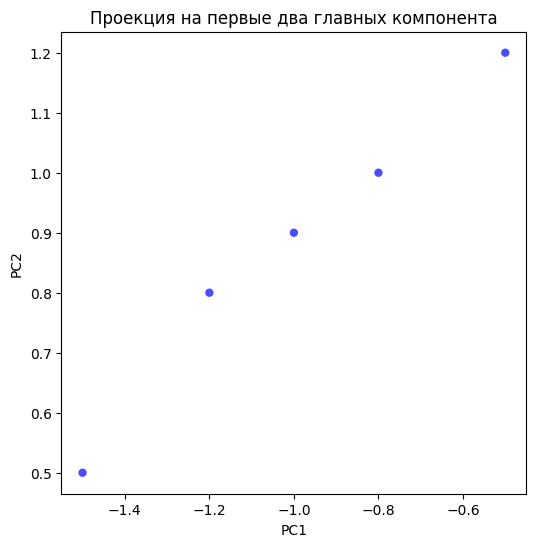

In [38]:
fig = plot_pca_projection(X_proj)
plt.show()

## 2.3.2 PCA

In [39]:
def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1) -> None:
    """
    Вход:
      X: матрица данных (n×m)
      noise_level: уровень шума (доля от стандартного отклонения)
    Выход: результаты PCA до и после добавления шума.
    В этом задании можете проявить творческие способности, поэтому выходные данные не типизированы
    """
    n, m = X.rows, X.cols

    # 1) Считаем PCA на исходных данных
    X_proj_original, gamma_original, k_used_original, W, means = pca(X)

    print(f"[До шума ] k={k_used_original}, Дисперсия={gamma_original:.4f}")

    #   2) Добавляем шум
    #   Для каждого столбца j найдём std_j (ст. откл.),
    #   шум ~ N(0, std_j * noise_level)
    means = [0.0] * m
    for j in range(m):
        col_sum = 0.0
        for i in range(n):
            col_sum += X[i, j]
        means[j] = col_sum / n

    stdevs = [0.0] * m
    for j in range(m):
        var_sum = 0.0
        for i in range(n):
            diff = X[i, j] - means[j]
            var_sum += diff * diff
        stdev = math.sqrt(var_sum / (n - 1)) if n > 1 else 0.0
        stdevs[j] = stdev

    X_noisy = X.copy()
    for i in range(n):
        for j in range(m):
            noise = random.gauss(0.0, stdevs[j] * noise_level)
            old_val = X_noisy[i, j]
            X_noisy.set(i, j, old_val + noise)

    # 3) Считаем PCA на зашумлённых данных
    X_proj_noisy, gamma_noisy, k_used_noisy, W, means = pca(X_noisy)

    print(f"[После добавки шума ] k={k_used_noisy}, Дисперсия={gamma_noisy:.4f}")

    diff_expl = gamma_noisy - gamma_original
    print(f"Разница в Дисперсиях: {diff_expl:.4f}")


In [40]:
X_test = Matrix([
    [1.0, 2.0, 3.0],
    [1.5, 2.2, 2.9],
    [2.0, 2.5, 3.2],
    [0.9, 1.8, 2.8],
    [1.2, 2.3, 3.1],
    [1.8, 2.1, 3.0],
    [4.0, 5.0, 6.0],
    [4.1, 5.2, 5.8],
    [4.2, 5.2, 5.9],
    [3.9, 4.8, 5.7],
    [4.3, 5.5, 6.1],
    [3.8, 5.1, 6.0],
    [7.2, 8.2, 8.9],
    [7.5, 8.1, 8.7],
    [7.8, 8.3, 8.8],
    [7.9, 8.2, 8.5],
    [7.4, 8.0, 8.6],
    [7.6, 8.4, 8.9],
    [10.1, 11.2, 12.3],
    [10.5, 11.0, 12.1],
    [9.9, 11.5, 12.4],
    [10.2, 11.3, 12.0],
    [10.0, 11.1, 12.2],
    [2.5, 3.5, 4.5],
    [2.6, 3.4, 4.6],
    [2.7, 3.6, 4.4],
    [2.4, 3.3, 4.7],
    [5.0, 2.0, 15.0],
    [0.5, 8.5, 4.0],
    [6.6, 6.6, 6.6],
    [9.0, 1.0, 7.0]
])


In [41]:
add_noise_and_compare(X_test, noise_level=0.2)

[До шума ] k=2, Дисперсия=0.9580
[После добавки шума ] k=2, Дисперсия=0.9410
Разница в Дисперсиях: -0.0170


### Применение PCA на реальных данных

Для начала скачаем датасетик с пивом)

Напишем вспомогательные функции для машинки

In [42]:
def separate_features_target(data_matrix: Matrix) -> Tuple[Matrix, Matrix]:
    """
    Выделяем целевую переменную (Efficiency)
    X содержит: [calories, abv, IBU, SRM, Price, User Rating]
    y: [Efficiency]
    """
    X_data = []
    y_data = []

    for i in range(data_matrix.rows):
        row = data_matrix.row(i)
        X_data.append(row[:6])  # Первые 6 признаков
        y_data.append([row[6]])  # Целевая переменная (Efficiency)

    return Matrix(X_data), Matrix(y_data)

In [43]:
def transform_pca(X: Matrix, W: Matrix, means: List[float]) -> Matrix:
    """
    Преобразует тестовые данные X по матрице W и средним значениям means,
    используя ту же центрировку, что и обучающие данные
    X_proj = (X - means) @ W
    """
    n, m = X.rows, X.cols
    # Центрируем X с использованием means из обучающей выборки
    X_centered_data = []
    for i in range(n):
        row = []
        for j in range(m):
            row.append(X[i, j] - means[j])
        X_centered_data.append(row)
    X_centered = Matrix(X_centered_data)
    return X_centered @ W

In [44]:
def add_intercept_column(X: Matrix) -> Matrix:
    """Добавляем столбец из 1 (интерсепт) слева: X' (n×(m+1))"""
    n, m = X.rows, X.cols
    new_data = []
    for i in range(n):
        row = [1.0]  # intercept
        for j in range(m):
            row.append(X[i, j])
        new_data.append(row)
    return Matrix(new_data)


def train_linear_regression(X: Matrix, y: Matrix) -> Matrix:
    """
    Решаем w = (X^T X)^(-1) X^T y  (Normal Equation)
    X: (n×m), y: (n×1)
    Возвращаем w: (m×1)
    """
    X_aug = add_intercept_column(X)
    XT = X_aug.transpose()

    try:
        A = XT @ X_aug
        B = XT @ y
        w_vec = solve_system(A, B)
        return Matrix([[val] for val in w_vec])
    except Exception as e:
        raise ValueError(f"Matrix inversion failed: {e}")


def predict_linear_regression(X: Matrix, w: Matrix) -> Matrix:
    """
    Предсказывает y = X_aug @ w
    X: (n×m), w: ((m+1)×1)
    Возвращает y_pred: (n×1)
    """
    X_aug = add_intercept_column(X)
    return X_aug @ w


def mse(y_true: Matrix, y_pred: Matrix) -> float:
    """
    Среднеквадратичная ошибка
    y_true, y_pred: (n×1)
    """
    n = y_true.rows
    sse = 0.0
    for i in range(n):
        diff = y_true[i, 0] - y_pred[i, 0]
        sse += diff ** 2
    return sse / n

Напишем функцию считывание датасета

In [45]:
def load_csv(file_path: str) -> Matrix:
    """Считывает датасет Beers из CSV-файла"""
    data = []
    with open(file_path, "r", encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Пропускаем заголовок

        for row_idx, row in enumerate(reader):
            if len(row) != 8:  # Проверяем 8 колонок
                print(f"Пропуск строки {row_idx}: неверное количество колонок")
                continue

            try:
                processed_row = [
                    int(row[1]),  # calories
                    float(row[2]),  # abv
                    int(row[3]),  # IBU
                    int(row[4]),  # SRM
                    float(row[5]),  # Price
                    float(row[6]),  # User Rating
                    float(row[7])  # Efficiency (целевая переменная)
                ]
                data.append(processed_row)

            except (ValueError, IndexError) as e:
                print(f"Пропуск строки {row_idx}: ошибка преобразования - {str(e)}")
                continue

    return Matrix(data)


In [46]:
def apply_pca_to_dataset(dataset_name: str, k: int) -> Tuple['Matrix', float]:
    """
    Вход:
      dataset_name: название датасета
      k: число главных компонент
    Выход: кортеж (проекция данных, качество модели)
    """
    # Загружаем датасет
    X = load_csv(dataset_name)

    # Разделяем данные на X и y
    X_data, y_data = separate_features_target(X)

    # Сохраняем исходные данные для сравнения
    X_original = X_data.copy()

    X_data_list = [X_original.row(i) for i in range(X_original.rows)]
    y_data_list = [y_data.row(i) for i in range(y_data.rows)]

    # Разделяем на обучающие и тестовые выборки
    split_index = int(0.7 * len(X_data_list))
    X_train = Matrix(X_data_list[:split_index])
    X_test = Matrix(X_data_list[split_index:])
    y_train = Matrix(y_data_list[:split_index])
    y_test = Matrix(y_data_list[split_index:])

    # Сравниваем метрики качества до и после PCA
    # Без применения PCA
    w_no_pca = train_linear_regression(X_train, y_train)
    y_pred_test_no_pca = predict_linear_regression(X_test, w_no_pca)
    no_pca_mse = mse(y_test, y_pred_test_no_pca)

    # С применением PCA
    X_train_pca, gamma, k_used, W, means_train = pca(X_train, k)
    X_test_pca = transform_pca(X_test, W, means_train)

    w_pca = train_linear_regression(X_train_pca, y_train)
    y_pred_test_pca = predict_linear_regression(X_test_pca, w_pca)
    pca_mse = mse(y_test, y_pred_test_pca)

    X_proj = X_train_pca

    # 7) Выводим результаты
    print(f"PCA на датасете '{dataset_name}':")
    print(f"  Исходные размерности: {X.rows} объектов, {X.cols} признаков.")
    print(f"  k_used={k_used}, доля объяснённой дисперсии={gamma:.4f}")
    print(f"  Итоговая матрица X_proj: {X_proj.rows}х{X_proj.cols}.")

    print("Метрики качества:")
    print(f"  MSE без PCA: {no_pca_mse:.4f}")
    print(f"  MSE с PCA: {pca_mse:.4f}")

    return X_proj, gamma

In [ ]:
apply_pca_to_dataset('D:/University_labs/linal/beers.csv', k=None)